In [1]:
import sys, logging
from pathlib import Path
import concurrent.futures
import pandas as pd
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Define the project root and add it to the path so we can run HECTRE.
PROJ_ROOT = Path('..', '..').resolve()
sys.path.insert(0, str(PROJ_ROOT))

In [3]:
# Reload the notebook if imported modules are modified.
%load_ext autoreload
%autoreload 2

In [4]:
# Import HECTRE and disable logging. We'll be creating a custom report in this notebook.
from hectre.metrics import accuracy
logging.disable()

In [5]:
TESTING=False
TEST_ROOT = Path(PROJ_ROOT, 'hectre', 'tests', 'test_data')
ad_control_cdfs = Path(TEST_ROOT, 'cdfs', 'eval_report', 'ad').iterdir()
db_control_cdfs = Path(TEST_ROOT, 'cdfs', 'eval_report', 'db').iterdir()
ad_control_cdfs = [{'type': 'ad', 'path': path} for path in ad_control_cdfs if path.is_file()]
db_control_cdfs = [{'type': 'db', 'path': path} for path in db_control_cdfs if path.is_file()]
control_cdfs = ad_control_cdfs + db_control_cdfs
ad_picos = "EASI-50;EASI-75;EASI-90"
db_picos = "HbA1c"
eval_data = {}

def get_eval_data(control_cdf_path):
    picos_input = ad_picos if control_cdf_path['type'] == 'ad' else db_picos
    slug = control_cdf_path['path'].stem.lower()
    pdf_path = Path(TEST_ROOT, slug + '.pdfdata')
    pdf_path_input = str(pdf_path)
    cdf_path_input = str(control_cdf_path['path'].resolve())
    control_cdf = pd.read_csv(cdf_path_input)
    if TESTING:
        test_cdf = pd.read_csv(Path(TEST_ROOT, 'cdfs', 'eval_report_test_cdfs', control_cdf_path.name).resolve())
    else:
        try:
            test_cdf = accuracy.accuracy_extract_test(pdf_path_input, picos_input)
        except Exception as e:
            print(e)
            return
    acc = accuracy.cdf_accuracy(
        test_cdf,
        control_cdf,
        slug
    )
    eval_data[slug] = acc
    time.sleep(15)

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(8) as executor:
    executor.map(get_eval_data, control_cdfs)

An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again. You have sent too many requests.  Wait before trying again.
An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again. You have sent too many requests.  Wait before trying again.
An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again. You have sent too many requests.  Wait before trying again.
An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again. You have sent too many requests.  Wait before trying again.
An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please w

In [6]:
# Stacked DF stylization
def set_index_colors(df, index_styles):
    # DataFrame of styles
    df1 = pd.DataFrame('', index=df.index, columns=df.columns)
    for index_style in index_styles:
        mask = df.index.isin([index_style['value']], level=index_style['name'])
        df1[mask] = f"background-color: {index_style['color']};"
    return df1

# HECTRE Performance Evaluation Report

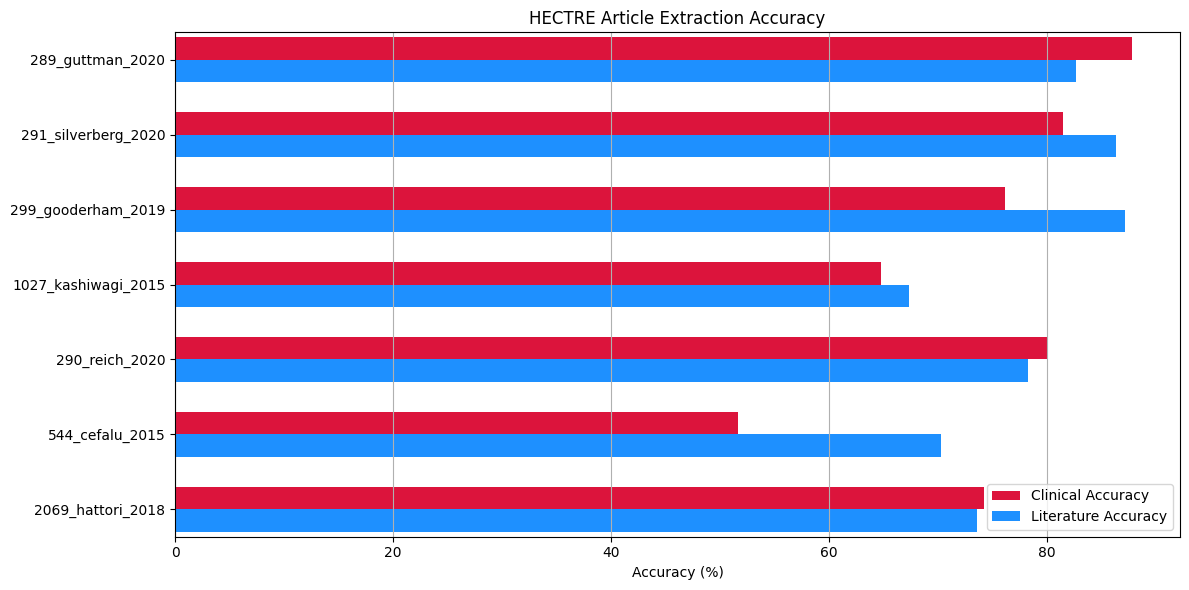

In [7]:
# Article slugs.
articles = ()
# stat_name: stat values.
stats = {}

for slug, data in eval_data.items():
    clin_values = data['comparison']['comp_values_clin']
    clinical_accuracy_data = clin_values[(clin_values.index.get_level_values('has_match') == 1)]
    clinical_accuracy = clinical_accuracy_data.mean(axis=None)
    literature_accuracy = data['lit_acc_pct']
    stats['Clinical Accuracy'] = stats.get('Clinical Accuracy', ()) + (clinical_accuracy,)
    stats['Literature Accuracy'] = stats.get('Literature Accuracy', ()) + (literature_accuracy,)
    articles += (slug,)
    
df = pd.DataFrame(stats)

ind = np.arange(len(df))
height = 0.3  # two times height needs to be at most 1

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(ind, df['Clinical Accuracy'], height, align='edge', alpha=1, color='crimson', label='Clinical Accuracy')
ax.barh(ind - height, df['Literature Accuracy'], height, align='edge', alpha=1, color='dodgerblue', label='Literature Accuracy')
ax.set_yticks(ind)
ax.set_yticklabels(articles, fontsize=10)
ax.grid(axis='x')

ax.set_xlabel('Accuracy (%)')
ax.set_title('HECTRE Article Extraction Accuracy')
ax.legend()
ax.margins(y=0.01)  # use smaller margins in the y-direction
plt.tight_layout()
plt.show()

# y = np.arange(len(eval_data.items()))  # Article index on y-axis.
# height = 0.25  # the height of the bars
# multiplier = 0

# fig, ax = plt.subplots()
# fmt = lambda x: '{:.2f}%'.format(x)
# for stat, data in stats.items():
#     offset = height * multiplier
#     rects = ax.barh(y + offset, data, height, label=stat, align='edge')
#     ax.bar_label(rects, padding=3, fmt=fmt)
#     multiplier += 1

# ax.set_xlabel('Accuracy (%)')
# ax.set_title('HECTRE Article Extraction Accuracy')
# ax.set_yticks(y, articles)
# ax.legend(loc='best', ncols=3)
# ax.set_xlim(0, 100)

# width = 12
# height = 8
# fig.set_size_inches(width, height)
# plt.show()

In [8]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.multi_sparse', False)
for slug, extraction in eval_data.items():
    display(Markdown(f'## {slug}'))
    display(Markdown(f"**Control rows matched by test output:** {extraction['matched_control_rows']} of {extraction['num_control_rows']}"))
    display(Markdown(f"**Literature data accuracy:** {extraction['lit_acc_pct']:.2f}%"))
    clin_values = extraction['comparison']['comp_values_clin']
    display(Markdown(f"**Clinical data accuracy:** {clin_values.mean(axis=None):.2f}%"))
    clin_values_drop_unmatched = clin_values[(clin_values.index.get_level_values('has_match') == 1)]
    display(Markdown(f"**Clinical data accuracy (drop unmatched):** {clin_values_drop_unmatched.mean(axis=None):.2f}%"))
    display(Markdown("### Test Output vs. Control Output and their Similarity"))
    index_styles = [
        {
            'name': 'sample',
            'value': 'similarity',
            'color': 'orange'
        },
        {
            'name': 'sample',
            'value': 'test',
            'color': 'skyblue'
        },
        {
            'name': 'sample',
            'value': 'control',
            'color': 'pink'
        },
        
    ]
    stacked_df = extraction['comparison']['stacked_df']
    stacked_df = stacked_df.style.apply(set_index_colors,axis=None, index_styles=index_styles)
    with pd.option_context('display.multi_sparse',False):
        display(stacked_df)

## 2069_hattori_2018

**Control rows matched by test output:** 2 of 4

**Literature data accuracy:** 73.60%

**Clinical data accuracy:** 37.13%

**Clinical data accuracy (drop unmatched):** 74.26%

### Test Output vs. Control Output and their Similarity

## 544_cefalu_2015

**Control rows matched by test output:** 8 of 8

**Literature data accuracy:** 70.33%

**Clinical data accuracy:** 51.70%

**Clinical data accuracy (drop unmatched):** 51.70%

### Test Output vs. Control Output and their Similarity

## 290_reich_2020

**Control rows matched by test output:** 4 of 66

**Literature data accuracy:** 78.33%

**Clinical data accuracy:** 4.85%

**Clinical data accuracy (drop unmatched):** 80.04%

### Test Output vs. Control Output and their Similarity

## 1027_kashiwagi_2015

**Control rows matched by test output:** 2 of 2

**Literature data accuracy:** 67.33%

**Clinical data accuracy:** 64.83%

**Clinical data accuracy (drop unmatched):** 64.83%

### Test Output vs. Control Output and their Similarity

## 299_gooderham_2019

**Control rows matched by test output:** 5 of 240

**Literature data accuracy:** 87.20%

**Clinical data accuracy:** 1.59%

**Clinical data accuracy (drop unmatched):** 76.15%

### Test Output vs. Control Output and their Similarity

## 291_silverberg_2020

**Control rows matched by test output:** 31 of 111

**Literature data accuracy:** 86.33%

**Clinical data accuracy:** 22.75%

**Clinical data accuracy (drop unmatched):** 81.46%

### Test Output vs. Control Output and their Similarity

## 289_guttman_2020

**Control rows matched by test output:** 10 of 68

**Literature data accuracy:** 82.73%

**Clinical data accuracy:** 12.92%

**Clinical data accuracy (drop unmatched):** 87.85%

### Test Output vs. Control Output and their Similarity